# Analyzing User Similarity using Github API
#
### A project based on data pulled from the githubarchive.org website
### All push events from 2013-04

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.sparse import coo_matrix
from itertools import combinations
import time

In [2]:
# Read in the data
df = pd.read_csv('push_data.csv')

In [3]:
# Clean the data
print(df.dropna().info())
df = df[~df.isnull().any(axis=1)]
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523117 entries, 0 to 523121
Data columns (total 4 columns):
repo_id        523117 non-null float64
repo_name      523117 non-null object
actor_login    523117 non-null object
count          523117 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 20.0+ MB
None
(523117, 4)
     repo_id      repo_name   actor_login  count
0  8524312.0       Firmware        rk3dov      6
1  9639491.0    Test_WebApp    rajesh4064     24
2  3659542.0         MoSync  mattiasbybro     89
3  8969848.0  OrphanRecords       abhidsm      7
4  9449201.0     resilience      julienrf      2


In [4]:
# Cast data to correct types
df.repo_id = df.repo_id.astype(dtype=np.uint32)
df.repo_name = df.repo_name.astype(dtype='category')
df.actor_login = df.actor_login.astype(dtype='category')
df['count'] = df[['count']].astype(dtype=np.uint32)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523117 entries, 0 to 523121
Data columns (total 4 columns):
repo_id        523117 non-null uint32
repo_name      523117 non-null category
actor_login    523117 non-null category
count          523117 non-null uint32
dtypes: category(2), uint32(2)
memory usage: 36.2 MB


In [5]:
# Compute repos that have more than one contributor
target = df.repo_id.value_counts()
target = target[target.values > 1]
print('Repos with overlap = %d' % len(target) )

Repos with overlap = 37404


301371 total repos. 
253972 total users. 


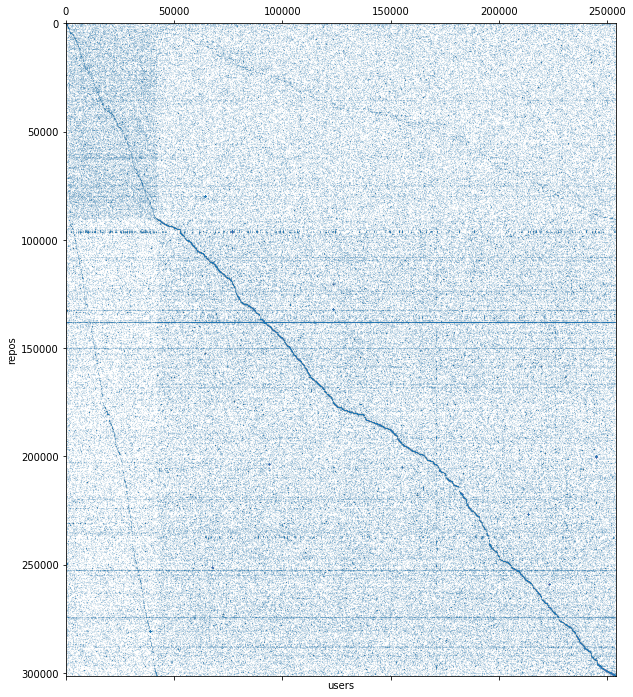

In [6]:
# Construct sparse matrix - rows = repos, columns = users, value = # push events
n_repos = df.repo_name.cat.codes.max() + 1
n_users = df.actor_login.cat.codes.max() + 1
print('%d total repos. ' % (n_repos) )
print('%d total users. ' % (n_users) )

coo = coo_matrix( (df['count'], (df.repo_name.cat.codes, df.actor_login.cat.codes) ) )
plt.figure(figsize=(12, 12))
plt.spy(coo, markersize=0.03)
plt.xlabel('users')
plt.ylabel('repos')
plt.show()

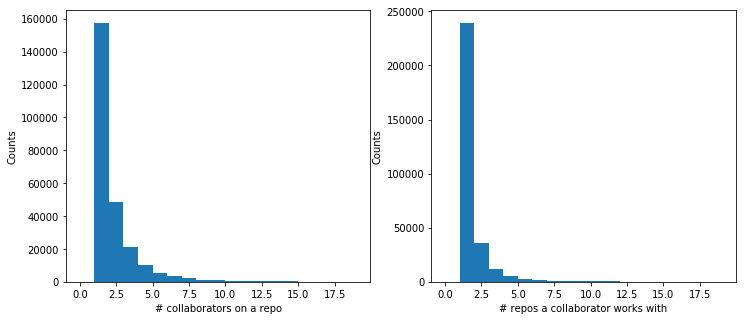

In [7]:
plt.figure(figsize=(12, 5))

# Histogram: the number of collaborators on each repo
x = np.squeeze(np.asarray(( coo != 0 ).sum(0)).transpose())
plt.subplot(1,2,1)
plt.hist(x, bins=np.arange(0,20))
plt.xlabel('# collaborators on a repo')
plt.ylabel('Counts')

# Histogram: the number of repos each user works on
y = np.squeeze(np.asarray(( coo != 0 ).sum(1)))
plt.subplot(1,2,2)
plt.hist(y, bins=np.arange(0,20))
plt.xlabel('# repos a collaborator works with')
plt.ylabel('Counts')

plt.show()


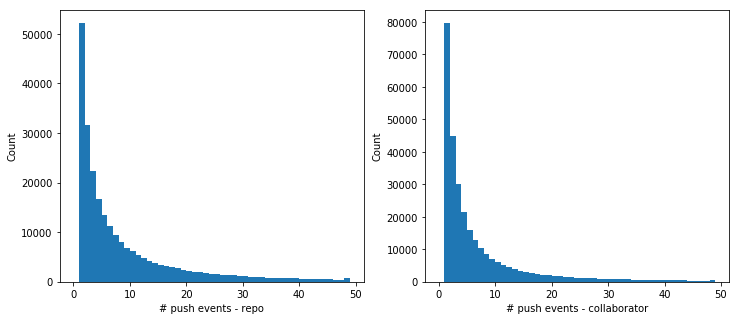

In [8]:
plt.figure(figsize=(12, 5))

# Histogram: the number of push events for each repo
x = np.squeeze(np.asarray(coo.sum(axis=0)).transpose())
plt.subplot(1,2,1)
plt.hist(x, bins=np.arange(0,50))
plt.xlabel('# push events - repo')
plt.ylabel('Count')

# Histogram: the number of push events per user
y = np.squeeze(np.asarray(coo.sum(axis=1)))
plt.subplot(1,2,2)
plt.hist(y, bins=np.arange(0,50))
plt.xlabel('# push events - collaborator')
plt.ylabel('Count')

plt.show()

In [9]:
print(len(x))
print(len(y))
print(coo.get_shape())

253972
301371
(301371, 253972)


In [10]:
# Calculate user similarity: dot product of user's repo vectors
start = time.time()
s_matrix = coo.T.dot(coo)
end = time.time()
print('elapsed time = %f' % (end-start))

elapsed time = 1.651757


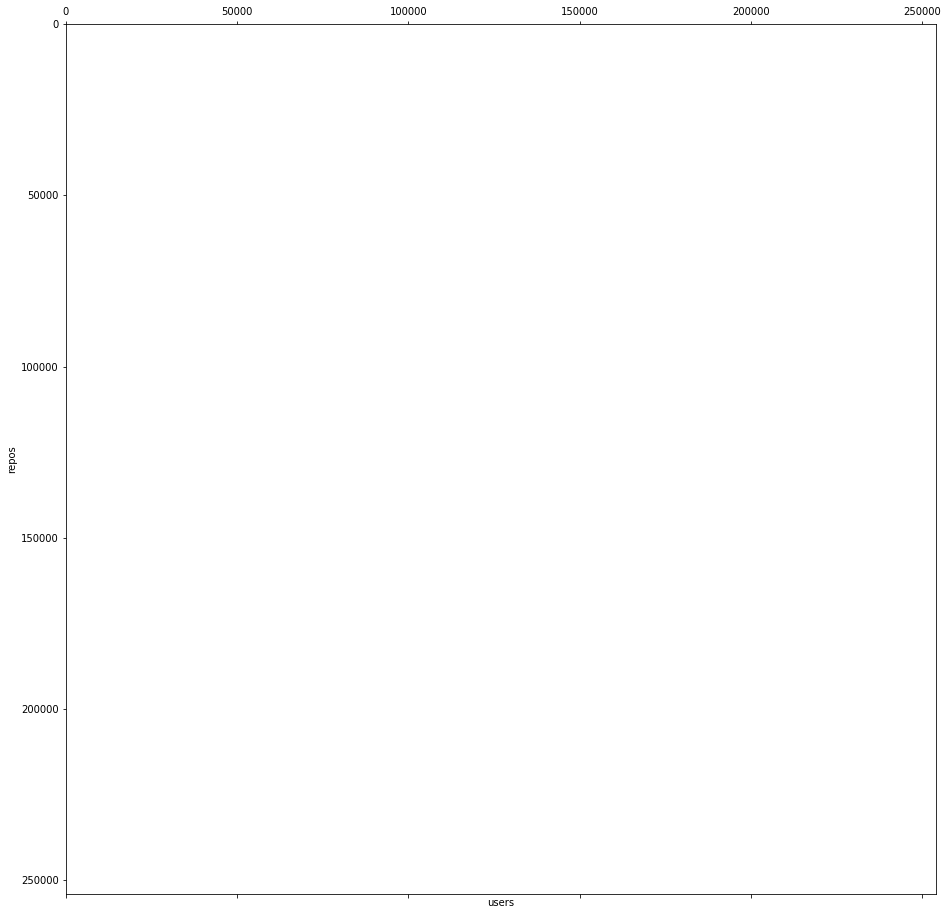

In [11]:
plt.figure(figsize=(16, 16))

mx = s_matrix.max()
plt.spy(s_matrix/mx, markersize=0.003)
plt.xlabel('users')
plt.ylabel('repos')
plt.show()

In [11]:
# Calculate some basic statistics from the similarity matrix
pct_filled = (s_matrix!=0).sum()/s_matrix.shape[0]**2
print('The similarity matrix is %f filled' % pct_filled)
print('Approximately 1 of every %f users commit to the any overlapping repos.\n' % (1/pct_filled))

s_matrix.max()
print('The maximum similarity score is %f' % s_matrix.max() )

The similarity matrix is 0.000930 filled
Approximately 1 of every 1074.848000 users commit to the any overlapping repos.

The maximum similarity score is 129322384.000000


In [12]:
s_matrix.mean()

0.035113948575162514

In [13]:
# Testing different methods for vector dot product
v1 = coo.getrow(0) 

start = time.time()
v2 = coo.getrow(0)
end = time.time()
print('elapsed time = %f' % (end-start))

#print(type(v1))
start = time.time()
v1.multiply(v2)
end = time.time()
print('elapsed time = %f' % (end-start))

start = time.time()
v1.dot(v2.transpose())
end = time.time()
print('elapsed time = %f' % (end-start))

elapsed time = 0.025017
elapsed time = 0.138093
elapsed time = 0.001001


In [14]:
# Print users with highest push numbers
print(df.sort_values(by='count', ascending=False).head())

        repo_id       repo_name            actor_login  count
409431  5002084  yhadoop-common              yahoo-bot   7711
90946   6058234          melete         mirror-updates   7136
409378  9241689        testrepo               test8590   6284
136451  8726831   BrandyMintApp                   dapi   5634
477556  7056093     ci-tracking  dellcloudedge-jenkins   5088


In [15]:
# Print repos with most pushes from Yahoo Bot
print(df[df['actor_login'] == 'yahoo-bot'].sort_values(by='count', ascending=False).head())

        repo_id       repo_name actor_login  count
409431  5002084  yhadoop-common   yahoo-bot   7711
500405  5125614           hbase   yahoo-bot    635
455162  5125637           oozie   yahoo-bot    237
364624  5125571            hive   yahoo-bot    107
412979  5125436             pig   yahoo-bot     32


In [16]:
# Get the sum of all commits from each user
user_sum = np.squeeze(coo.sum(axis=0)).A[0]
assert(len(user_sum) == n_users)
print('The size of user_sum array is %d' % len(user_sum))

The size of user_sum array is 253972


In [22]:
# Print the user with the most pushes total
mask = user_sum == user_sum.max()
user_id = np.where(mask)[0][0]
user_name = df.actor_login.cat.categories[user_id] 
print('The user with the most pushes is %d : %s \n' % (user_id, user_name) )

# Make sure that the sparse matrix is consistent with the data frame 
print("Sum of %s's pushes = %d" % (user_name, max_user.sum()) )
idx = df['actor_login'] ==  user_name
print("Sum of %s's pushes = %d \n" % (user_name, df['count'][idx].sum()) )
assert( max_user.sum() == df['count'][idx].sum() )

# Print users data
max_user = coo.getcol(user_id)
print(df[idx])

The user with the most pushes is 65902 : boost-jenkins 

Sum of boost-jenkins's pushes = 31325
Sum of boost-jenkins's pushes = 31325 

        repo_id           repo_name    actor_login  count
222     7589941                bind  boost-jenkins    713
223     7589914              assign  boost-jenkins    376
23114   7590023              config  boost-jenkins    608
23579   7590011          functional  boost-jenkins    564
24783   7589994        interprocess  boost-jenkins     76
25130   7589980      function_types  boost-jenkins     51
45352   7590014          statechart  boost-jenkins     67
45353   7590013        preprocessor  boost-jenkins    462
45835   7589969              fusion  boost-jenkins     68
45836   7589962               tuple  boost-jenkins     87
46731   7589956             polygon  boost-jenkins     11
51857   8684885         langbinding  boost-jenkins      2
68207   7589983               array  boost-jenkins     66
68949   7589917            signals2  boost-jenkins   

In [23]:
# Print out report for a given user
# For reference, Mattn committed 4 times to mruby-require in April, 2013
# https://github.com/mattn/mruby-require/commits/master?after=ff56b560df1184c307391b96cc45bc7668a32bcf+69
num1 = df.actor_login.cat.codes == 1
num1 = np.where(num1)

u_idx = df.actor_login.cat.codes[num1[0][0]]
u_name = df.actor_login.cat.categories[u_idx]

print('User id number %d is %s ' % (u_idx, u_name))
print(df[df['actor_login'] == u_name])

User id number 163499 is mattn 
        repo_id             repo_name actor_login  count
1276    7475629         mruby-require       mattn      4
11461    914626            webapi-vim       mattn      4
28623   4086877              mruby-uv       mattn      7
38457   2640484     sonictemplate-vim       mattn      2
44448   2180098             go-xmlrpc       mattn      1
56632   9487786      go-lingrimagebot       mattn      3
57906   8745574        mruby-lingrbot       mattn      4
58810   2770074              go-adodb       mattn      2
82665   2696338     lingr-radar-linux       mattn      6
90218    386671                go-gtk       mattn      1
90683   9804306                signal       mattn      1
99926     69663              gist-vim       mattn      2
103814  9522515      golang_herokubot       mattn      4
113144  9313946               pyLingr       mattn      1
118913  2141023              go-uwsgi       mattn      7
136294  9189972           go-lingrbot       mattn     16

In [24]:
usr = 2

# Get index of users that shared any repos with usr
indices = s_matrix.getcol(usr).nonzero()[0]
print(indices)

# Create similarity score vector
similarity_scores = []

c1 = coo.getcol(usr)
for u in indices:
    c2 = coo.getcol(u)
    similarity_scores.append( c1.T.dot(c2).data[0] )

[     2    112    374   1333   2056   3329   3335   4690   4802   5552
   5700   6302   6423   8003   8672   8822   8838   8846   9769  10078
  11915  11984  12798  13420  14634  15750  16490  19464  19818  20337
  22759  23285  23509  23991  24969  25460  25868  26233  26562  28137
  29824  29868  30867  31282  35100  35131  36378  36638  36670  36945
  37293  39040  40427  46434  46978  52538  52558  54233  59366  61555
  64595  65902  66750  68872  68962  72961  74147  75780  76780  79019
  79900  80499  85148  86242  87910  88111  90101  92640  92985  93518
  96789  97682  98479  98950  99100  99690 100163 100708 100976 102888
 103636 103854 106875 111492 112305 114743 115367 116707 119200 120302
 121032 122697 122794 124309 125787 131483 131664 132861 135096 135275
 137981 138351 143140 145702 146787 146843 147503 147999 148631 149401
 151672 152320 152716 153671 153816 153893 155296 157378 159903 160297
 164220 164548 166230 170090 170715 171514 173703 176842 177426 178951
 18108

In [25]:
# Check that both methods give same result
method_sparse_matrix = s_matrix.getcol(usr).sum()
method_manual_calc = np.array(similarity_scores).sum()
assert(method_sparse_matrix == method_manual_calc)

print('Both methods return column sum of %d. ' % np.array(similarity_scores).sum())

Both methods return column sum of 39722. 
